In [1]:
import torch
import numpy as np
from torch import nn
from tqdm.auto import tqdm
from torchvision import datasets
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!
from torchsummary import summary
import torch.nn.functional as F
from GaussianNoise import decay_gauss_std,set_gauss_std



# library to get dataloader
from dataloaders import get_pkmn_dataloader

# library to get loss functions
from loss_functions import get_generator_loss_func,get_disc_loss_func,gradient_penalty,get_gradient

# generators and discriminators
from DCGeneratorCustom import DCGeneratorCustom
from DCDiscriminatorCustom import DCDiscriminatorCustom
from DCGeneratorStandard import DCGeneratorStandard
from DCDiscriminatorStandard import DCDiscriminatorStandard
from DCDiscriminatorStandardDropout import DCDiscriminatorStandardDropout
from DiscriminatorPatchGAN import DiscriminatorPatchGAN,DiscriminatorPatchGANConditional
from DCGeneratorConditionalLarge import DCGeneratorConditionalLarge
from LatentDiscriminatorNetwork import LatentDiscriminatorNetwork

from DCGeneratorConditional import DCGeneratorConditional
from DCGeneratorConditionalLarge import DCGeneratorConditionalLarge
from DCDiscriminatorConditional import DCDiscriminatorConditional
from DCDiscriminatorConditionalLarge import DCDiscriminatorConditionalLarge
from UNetArchitecture import UNet,UNetConditional,UNetConditionalImage

# util methods
from utils import get_noise,get_image_noise,get_incorrect_labels_for_real

# constants
from pkmn_constants import PKMN_TYPES,CLASS_IDX_2_PKMN_TYPE,NUM_PKMN_TYPES,REDUCED_PKMN_TYPES,CLASS_IDX_2_PKMN_TYPE_REDUCED

# whether to use CPU/GPU (pass this along everywhere)
device_str = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device(device_str)

print("Using device: {}".format(device_str))


torch.cuda.empty_cache()

Using device: cpu


In [2]:
print(torch.__version__)

# if apply_denormalization is true, then we re-scale the images back 
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28), denorm_transform = None, use_uniform_transform = False):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    
    # We don't specifically need this since we are doing the denormalization ourself
    
    if denorm_transform is not None:
      assert use_uniform_transform == False
      image_tensor = denorm_transform(image_tensor)
    if use_uniform_transform:
      # cannot use both uniform and denorm transform together
      assert denorm_transform == None
      image_tensor = (image_tensor + 1) / 2 # scale from [-1, 1] to [0, 1] space
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

def save_model(model, output_filename):
  torch.save(model.state_dict(), output_filename)

1.10.2


In [19]:
# ======= Define the basic hyper-parameters =====


# training epochs
n_epochs = 1

# Generator parameters
use_unet_image = False
use_unet_conditional = True

assert use_unet_image != use_unet_conditional

# Parameters used for all four models
z_dim = 16
debug = True


# Parameters for Generator (Latent --> Image). Assume UNetConditional generator architecture
hidden_dim_gen = 4
use_gen_class_embed = True
gen_class_embed_size = 16
use_mapping_network = False
map_network_hidden_size = 1024 # only used in UnetConditional
use_conditional_layer_arch = True
use_gen_dropout = False
dropout_gen_prob = 0.1
vocab_size = 13
use_gen_noise = False # whether or not to inject noise to gen layers using the class
use_class_ada_layer = True
class_adapt_layer_embed_size = 32
use_middle_noise = True
middle_noise_std = 0.02


# Parameters for Encoder (Image --> Latent). Same architecture as a discriminator except a final linear layer
encoder_use_patchgan_disc=False
encoder_use_dropout_disc = True
encoder_patchgan_dropout = 0.1
encoder_hidden_dim_disc = 4 # was 64
encoder_disc_class_embed_size = 4
encoder_use_class_embed_disc = True
encoder_early_dropout = 0.4
encoder_mid_dropout = 0.2
encoder_late_dropout = 0.1
encoder_use_gaussian_noise = True
encoder_gaussian_noise_std = 0.1
encoder_use_class_proj = False
encoder_use_custom_output_units = True # needed for encoder 
encoder_custom_output_units = z_dim

# Parameters for Image space discriminator. D(image) --> P(real)
image_disc_use_patchgan_disc=False
image_disc_use_dropout_disc = True
image_disc_patchgan_dropout = 0.1
image_disc_hidden_dim_disc = 4 # was 64
image_disc_disc_class_embed_size = 4
image_disc_use_class_embed_disc = True
image_disc_early_dropout = 0.4
image_disc_mid_dropout = 0.2
image_disc_late_dropout = 0.1
image_disc_use_gaussian_noise = True
image_disc_gaussian_noise_std = 0.1
image_disc_use_class_proj = False

# Parameters for Latent space discriminator D(latent) --> P(real)
latent_disc_use_class_embed = True
latent_disc_class_embed_size = 16
latent_disc_hidden_size = 32 # 96 is big enough tho
latent_disc_use_gaussian_noise = False
latent_dist_gaussian_noise_std = 0.1


# General Parameters - batch size and dataset
batch_size = 64
dataloader_name = "conditional_64_no_shiny_mainclass_flip_rotate_standard_norm"
#"conditional_64_dim_no_shiny_with_flip_and_rotate_and_standard_norm"
#"conditional_64_dim_mainclass_with_shiny_flip_rotate_custom_norm"

# how often to display images and debug info. Basically, the numerator is how many images you want to
# process before showing some debug info
display_step = int((4000 / batch_size))
periodic_saving = True
# after how many epochs do you save the model?
epoch_save_step = 20
save_prefix = "experiment_16/test_unet_and_dcdiscriminator_class_proj_conditional_layer"
imgs_to_display = 10

print("Planning to display images every {} steps".format(display_step))

gen_lr = 0.0002 # 0.0002 works for both, but takes at least 10-15 epochs before anything interesting happens?
disc_lr = 0.0002
beta_1 = 0.5
beta_2 = 0.999
disc_repeats = 1
gen_repeats = 1


# used to weight the different components of the generator loss (relative to image reconstruction)
alpha_reconstruct_image = 1
alpha_reconstruct_latent = 0.5
alpha_discriminate_image = 0.005 # seems too low, might increase by 10x or even 100x if u really care
alpha_discriminate_latent = 0.1

# todo: check if the discriminator is really outputting logits ?

# loss functions used
criterion_gen = nn.BCELoss() # assumes sigmoid has already been applied (!) Not true in the patchGAN case.
criterion_recon_image = nn.L1Loss()
criterion_recon_latent = nn.MSELoss()


assert imgs_to_display <= batch_size

Planning to display images every 62 steps


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


length of dataset (number of steps) is: 116, total size is: 7424


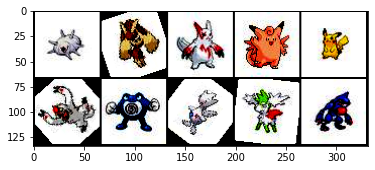

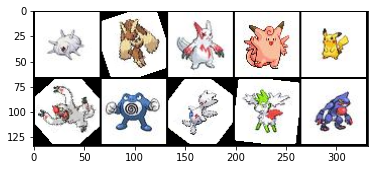

In [9]:
# Create the dataloader, based on the appropriate batch size. 

use_reduced_types = True
show_preview = True

pkmn_dataloader, denorm_transform = get_pkmn_dataloader(dataloader_name, batch_size,num_workers=0)
test_size = 10

# show a batch before and after denorm
test_data_iter = iter(pkmn_dataloader)
test_images, test_labels = next(test_data_iter)

print("length of dataset (number of steps) is: {}, total size is: {}".format(len(pkmn_dataloader), len(pkmn_dataloader)*batch_size))

if show_preview:
  show_tensor_images(test_images[0:test_size], num_images = test_size, size = (3,64,64), denorm_transform = None)
  show_tensor_images(test_images[0:test_size], num_images = test_size, size = (3,64,64), denorm_transform = denorm_transform)

if use_reduced_types:
  valid_types = REDUCED_PKMN_TYPES
  class_idx_to_type = CLASS_IDX_2_PKMN_TYPE_REDUCED
else:
  valid_types = PKMN_TYPES
  class_idx_to_type = CLASS_IDX_2_PKMN_TYPE
  
num_pkmn_types = len(valid_types)

In [12]:
# Create all the models here

# 1.) Generator (Latent --> Image)


gen = UNetConditional(z_dim = z_dim, 
                        hidden_channels= hidden_dim_gen,
                        input_dim = 64, 
                        use_dropout = use_gen_dropout, dropout_prob = dropout_gen_prob,
                        vocab_size = num_pkmn_types,
                        use_class_embed=use_gen_class_embed, class_embed_size=gen_class_embed_size,
                        use_mapping_network = use_mapping_network, map_network_hidden_size = map_network_hidden_size,
                        inject_noise = use_gen_noise, use_class_adapt_layer = use_class_ada_layer,
                        class_adapt_layer_embed_size = class_adapt_layer_embed_size
                        ).to(device)


# 2.) Image space Discriminator

if image_disc_use_patchgan_disc:
    print("Using patchgan discriminator for image space!")
    disc = DiscriminatorPatchGANConditional(hidden_channels = image_disc_hidden_dim_disc,              
                                            use_dropout = image_disc_use_dropout_disc, 
                                            input_image_dim = 64,
                                            dropout_prob = image_disc_patchgan_dropout,
                                            class_embed_size = image_disc_disc_class_embed_size,
                                            use_gaussian_noise = image_disc_use_gaussian_noise,
                                            gaussian_noise_std = image_disc_gaussian_noise_std,
                                            use_class_proj = image_disc_use_class_proj,
                                            num_pkmn_types = num_pkmn_types).to(device)

else:
    print("Using dc discriminator for image space!")
    disc = DCDiscriminatorConditional(hidden_dim = image_disc_hidden_dim_disc, 
                                      class_embed_size=image_disc_disc_class_embed_size,
                                      use_dropout = image_disc_use_dropout_disc, 
                                      early_dropout= image_disc_early_dropout, 
                                      mid_dropout = image_disc_mid_dropout,
                                      late_dropout = image_disc_late_dropout, 
                                      use_gaussian_noise = image_disc_use_gaussian_noise,
                                      gaussian_noise_std = image_disc_gaussian_noise_std,
                                      use_class_proj = image_disc_use_class_proj,
                                      num_pkmn_types = num_pkmn_types).to(device)
    
    
# 3.) Encoder
if encoder_use_patchgan_disc:
    print("Using patchGAN architecture for encoder!")
    encoder = DiscriminatorPatchGANConditional(hidden_channels = encoder_hidden_dim_disc,              
                                            use_dropout = encoder_use_dropout_disc, 
                                            input_image_dim = 64,
                                            dropout_prob = encoder_patchgan_dropout,
                                            class_embed_size = encoder_disc_class_embed_size,
                                            use_gaussian_noise = encoder_use_gaussian_noise,
                                            gaussian_noise_std = encoder_gaussian_noise_std,
                                            use_class_proj = encoder_use_class_proj,
                                            num_pkmn_types = num_pkmn_types).to(device)

else:
    print("Using dc discriminator architecture for encoder!")
    encoder = DCDiscriminatorConditional(hidden_dim = encoder_hidden_dim_disc, 
                                      class_embed_size=encoder_disc_class_embed_size,
                                      use_dropout = encoder_use_dropout_disc, 
                                      early_dropout= encoder_early_dropout, 
                                      mid_dropout = encoder_mid_dropout,
                                      late_dropout = encoder_late_dropout, 
                                      use_gaussian_noise = encoder_use_gaussian_noise,
                                      gaussian_noise_std = encoder_gaussian_noise_std,
                                      use_class_proj = encoder_use_class_proj,
                                      num_pkmn_types = num_pkmn_types,
                                      use_custom_output_units = encoder_use_custom_output_units,
                                      custom_output_units = encoder_custom_output_units).to(device)
    

# 4.) Latent space discriminator

disc_latent = LatentDiscriminatorNetwork(z_dim = z_dim,
                                                 use_class_embed = latent_disc_use_class_embed, 
                                                 class_embed_size = latent_disc_class_embed_size, 
                                                 vocab_size = num_pkmn_types,
                                                 initial_hidden_size = latent_disc_hidden_size, 
                                                 use_gaussian_noise = latent_disc_use_gaussian_noise, 
                                                 gaussian_noise_std = latent_dist_gaussian_noise_std)


    
  
gen_opt = torch.optim.Adam(gen.parameters(), lr=gen_lr, betas=(beta_1, beta_2))
disc_opt = torch.optim.Adam(disc.parameters(), lr=disc_lr, betas=(beta_1, beta_2))
encoder_opt = torch.optim.Adam(encoder.parameters(), lr=disc_lr, betas=(beta_1, beta_2))
disc_latent_opt = torch.optim.Adam(disc_latent.parameters(), lr=disc_lr, betas=(beta_1, beta_2))


def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)
encoder = encoder.apply(weights_init)
disc_latent = disc_latent.apply(weights_init)

# todo: add summaries for all models here

Using class adapative layer!!!
Using dc discriminator for image space!
==== Using dropout in discriminator!!
=== Using gaussian noise with std: 0.1
=== Using gaussian noise with std: 0.1
=== Using gaussian noise with std: 0.1
=== Using gaussian noise with std: 0.1
=== Using gaussian noise with std: 0.1
Using dc discriminator architecture for encoder!
==== Using dropout in discriminator!!
=== Using gaussian noise with std: 0.1
=== Using gaussian noise with std: 0.1
=== Using gaussian noise with std: 0.1
=== Using gaussian noise with std: 0.1
=== Using gaussian noise with std: 0.1


In [21]:
# summarize image generator
summary(gen, [(1, 16), (1,1)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Embedding-1             [-1, 1, 1, 16]             208
            Conv2d-2            [-1, 4, 64, 64]               8
   FeatureMapBlock-3            [-1, 4, 64, 64]               0
            Conv2d-4            [-1, 8, 64, 64]             296
       BatchNorm2d-5            [-1, 8, 64, 64]              16
         LeakyReLU-6            [-1, 8, 64, 64]               0
            Conv2d-7            [-1, 8, 64, 64]             584
       BatchNorm2d-8            [-1, 8, 64, 64]              16
         LeakyReLU-9            [-1, 8, 64, 64]               0
        MaxPool2d-10            [-1, 8, 32, 32]               0
 ContractingBlock-11            [-1, 8, 32, 32]               0
        Embedding-12             [-1, 1, 1, 32]             576
           Linear-13                    [-1, 8]             264
           Linear-14                   

In [24]:
# summarize encoder (latent generator)
summary(encoder, [(3, 64, 64), (1,1)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Embedding-1                    [-1, 4]              72
     GaussianNoise-2            [-1, 4, 64, 64]               0
            Conv2d-3            [-1, 4, 32, 32]             260
       BatchNorm2d-4            [-1, 4, 32, 32]               8
         LeakyReLU-5            [-1, 4, 32, 32]               0
         Dropout2d-6            [-1, 4, 32, 32]               0
     GaussianNoise-7            [-1, 4, 32, 32]               0
            Conv2d-8            [-1, 8, 16, 16]             520
       BatchNorm2d-9            [-1, 8, 16, 16]              16
        LeakyReLU-10            [-1, 8, 16, 16]               0
    GaussianNoise-11            [-1, 8, 16, 16]               0
           Conv2d-12             [-1, 16, 8, 8]           2,064
      BatchNorm2d-13             [-1, 16, 8, 8]              32
        LeakyReLU-14             [-1, 1

TypeError: can't multiply sequence by non-int of type 'tuple'

In [26]:
# summarize image discriminator
summary(disc, [(3, 64, 64), (1,1)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Embedding-1                    [-1, 4]              72
     GaussianNoise-2            [-1, 4, 64, 64]               0
            Conv2d-3            [-1, 4, 32, 32]             260
       BatchNorm2d-4            [-1, 4, 32, 32]               8
         LeakyReLU-5            [-1, 4, 32, 32]               0
         Dropout2d-6            [-1, 4, 32, 32]               0
     GaussianNoise-7            [-1, 4, 32, 32]               0
            Conv2d-8            [-1, 8, 16, 16]             520
       BatchNorm2d-9            [-1, 8, 16, 16]              16
        LeakyReLU-10            [-1, 8, 16, 16]               0
    GaussianNoise-11            [-1, 8, 16, 16]               0
           Conv2d-12             [-1, 16, 8, 8]           2,064
      BatchNorm2d-13             [-1, 16, 8, 8]              32
        LeakyReLU-14             [-1, 1

TypeError: can't multiply sequence by non-int of type 'tuple'

In [28]:
# summarize latent discriminator

summary(disc_latent, [(1, 16), (1,1)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Embedding-1             [-1, 1, 1, 16]             208
          Identity-2                   [-1, 32]               0
            Linear-3                   [-1, 32]           1,056
       BatchNorm1d-4                   [-1, 32]              64
         LeakyReLU-5                   [-1, 32]               0
          Identity-6                   [-1, 32]               0
            Linear-7                   [-1, 64]           2,112
       BatchNorm1d-8                   [-1, 64]             128
         LeakyReLU-9                   [-1, 64]               0
         Identity-10                   [-1, 64]               0
           Linear-11                  [-1, 128]           8,320
      BatchNorm1d-12                  [-1, 128]             256
        LeakyReLU-13                  [-1, 128]               0
         Identity-14                  [

In [20]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

cur_step = 0
generator_losses = []
discriminator_losses = []
discriminator_fake_preds = [] # median value of P(real) the discriminator predicts on the fake images (per batch)
discriminator_real_preds = [] # median value of P(real) the discriminator predicts on the real images (per batch)

agg_func = nn.Identity()

for epoch in range(n_epochs):
    # Dataloader returns the (real_images, labels)
    for real, true_labels in tqdm(pkmn_dataloader):
      
        cur_batch_size = len(real)
        real = real.to(device)
        true_labels = true_labels.to(device)
        
        mean_iteration_discriminator_loss = 0
        for _ in range(disc_repeats):
          
            ### Update discriminators ###
            disc_opt.zero_grad()
            disc_latent.zero_grad()
            
            real_noise = get_noise(cur_batch_size, z_dim, device=device)
            
            # don't want to backprop into the generator/encoder when getting the predictions
            with torch.no_grad():
              fake_images = gen(real_noise, true_labels)
              fake_noise = encoder(real, true_labels)
              # as in cycleGAN, try to reconstruct the original images and latent space
              recon_images = gen(fake_noise, true_labels)
              recon_noise = encoder(fake_images, true_labels)
              
            disc_image_real_pred = disc(real, true_labels)
            disc_image_fake_pred = disc(fake_images, true_labels)
            disc_image_recon_pred = disc(recon_images, true_labels)
            disc_latent_real_pred = disc_latent(real_noise, true_labels)
            disc_latent_fake_pred = disc_latent(fake_noise, true_labels)
            disc_latent_recon_pred = disc_latent(recon_noise, true_labels)

            target_ones = torch.ones_like(disc_image_real_pred, device = device)
            target_zeros = torch.zeros_like(disc_image_fake_pred, device = device)

            # todo: check if the criteria corresponds to the correct output of the network (ie. logits or not)
            X_loss = 2 * criterion_gen(disc_image_real_pred, target_ones)
            X_hat_loss = criterion_gen(disc_image_fake_pred, target_zeros)
            # I'm a bit confused why this is a target zero but whatever...
            X_tilde_loss = criterion_gen(disc_image_recon_pred, target_zeros)
            
            Z_loss = 2 * criterion_gen(disc_latent_real_pred, target_ones)
            Z_hat_loss = criterion_gen(disc_latent_fake_pred, target_zeros)
            Z_tilde_loss = criterion_gen(disc_latent_recon_pred, target_zeros)

            loss_images = (X_loss + X_hat_loss + X_tilde_loss) / 4
            loss_latent = (Z_loss + Z_hat_loss + Z_tilde_loss) / 4
            disc_loss = loss_images + loss_latent

            # backprop the loss
            disc_loss.backward()
            
            # update optimizers
            disc_opt.step()
            disc_latent_opt.step()            
            
            # Keep track of the average discriminator loss in this batch
            mean_iteration_discriminator_loss += disc_loss.item() / disc_repeats
            
            if debug:
              print("Discriminator image loss: {}, latent loss: {}".format(loss_images.item(), loss_latent.item()))
            
                        
        discriminator_losses += [mean_iteration_discriminator_loss]
        # notice this only takes the last one from the iteration (if you run the discriminator multiple times)
        # use a Sigmoid here to go from logits back into the P(real) space
        discriminator_fake_preds += [agg_func(torch.mean(disc_image_fake_pred).detach())]
        discriminator_real_preds += [agg_func(torch.mean(disc_image_real_pred).detach())]

        ### Update generator ###
        mean_iteration_gen_loss = 0
        for _ in range(gen_repeats):
          gen_opt.zero_grad()
          encoder_opt.zero_grad()
          
          # compute gen loss
          
          real_noise_2 = get_noise(cur_batch_size, z_dim, device=device)   
          
          fake_images = gen(real_noise_2, true_labels)
          fake_noise = encoder(real, true_labels)
          # as in cycleGAN, try to reconstruct the original images and latent space
          recon_images = gen(fake_noise, true_labels)
          recon_noise = encoder(fake_images, true_labels)     
          
          # get predictins on the fake and reconstructed images
          disc_image_fake_pred = disc(fake_images, true_labels)
          disc_image_recon_pred = disc(recon_images, true_labels)
          disc_latent_fake_pred = disc_latent(fake_noise, true_labels)
          disc_latent_recon_pred = disc_latent(recon_noise, true_labels)
          
          target_ones = torch.ones_like(disc_image_fake_pred, device = device)
          
          # similar to the original GAN, the generator wants the discriminator to think all the fake predictions
          # are true with probability equal to 1 ?
          X_hat_loss = criterion_gen(disc_image_fake_pred, target_ones)
          Z_hat_loss = criterion_gen(disc_latent_fake_pred, target_ones)
          X_tilde_loss = criterion_gen(disc_image_recon_pred, target_ones)
          Z_tilde_loss = criterion_gen(disc_latent_recon_pred, target_ones)

          # add reconstruction losses
          X_recon_loss = criterion_recon_image(recon_images, real) * alpha_reconstruction_image
          Z_recon_loss = criterion_recon_latent(recon_noise, real_noise_2) * alpha_reconstruction_latent

          X_loss = (X_hat_loss + X_tilde_loss) / 2 * alpha_discriminate_image
          Z_loss = (Z_hat_loss + Z_tilde_loss) / 2 * alpha_discriminate_latent          
          
          gen_loss = X_loss + Z_loss + X_recon_loss + Z_recon_loss
          
          mean_iteration_gen_loss += gen_loss.item() / gen_repeats
          
          # backprop the generator
          gen_loss.backward()

          # Update the weights
          gen_opt.step()
          encoder_opt.step()
          
          if debug:
            image_recon_loss = X_recon_loss.item()
            latent_recon_loss = Z_recon_loss.item()
            image_adv_loss = X_loss.item()
            latent_adv_loss = Z_loss.item()
            print("Generator losses: image recon: {}, latent recon: {}, image adv: {}, latent adv: {}".format(image_recon_loss, latent_recon_loss, image_adv_loss, latent_adv_loss))

        # Keep track of the average generator loss
        generator_losses += [mean_iteration_gen_loss]
        
        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            disc_mean = sum(discriminator_losses[-display_step:]) / display_step
            # maybe print out the last values here ? To see how stable it is overtime ? These all seem to be very close to 0.5 / 1
            disc_prediction_real = sum(discriminator_real_preds[-display_step:]) / display_step
            disc_prediction_fake = sum(discriminator_fake_preds[-display_step:]) / display_step
            print(f"Step {cur_step}: Epoch: {epoch}: Generator loss: {gen_mean}, discriminator loss: {disc_mean} mean disc pred on real images: {disc_prediction_real}, fake images: {disc_prediction_fake}")
            show_tensor_images(fake[0:imgs_to_display], imgs_to_display, size = (3,64,64), denorm_transform = denorm_transform)
            show_tensor_images(real[0:imgs_to_display], imgs_to_display, size = (3,64,64), denorm_transform = denorm_transform)
            
            ground_truth_types = [class_idx_to_type[class_idx] for class_idx in true_labels[0:imgs_to_display].cpu().numpy()]
            print("Pokemon types we are trying to generate are: {} \n    \t \t \t \t \t {}".format(ground_truth_types[0:5], ground_truth_types[5:]))
            
            step_bins = 20
            
            # todo: add proper labels to this plot
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(discriminator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="discriminator Loss"
            )
            plt.legend()
            plt.show()
        
        # increase the current step (ie. one batch)
        cur_step += 1
        
    if periodic_saving and epoch % epoch_save_step == 0 and epoch > 0:
      outfile_name = "{}_{}.pt".format(save_prefix, cur_step)
      print("===== Saving intermediate model with name {} ! ====".format(outfile_name))
      save_model(gen, outfile_name)

  0%|          | 0/116 [00:00<?, ?it/s]

Discriminator image loss: 0.7026914358139038, latent loss: 0.6796355247497559
Generator losses: image recon: 0.03266977146267891, latent recon: 0.10542219132184982, image adv: 0.004201347008347511, latent adv: 0.0793435201048851
Discriminator image loss: 0.7037473917007446, latent loss: 0.6767772436141968
Generator losses: image recon: 0.031596653163433075, latent recon: 0.10288970917463303, image adv: 0.00420542573556304, latent adv: 0.0801079198718071
Discriminator image loss: 0.7027486562728882, latent loss: 0.6695716381072998
Generator losses: image recon: 0.03182842582464218, latent recon: 0.1115289106965065, image adv: 0.004188958089798689, latent adv: 0.08110008388757706
Discriminator image loss: 0.704437792301178, latent loss: 0.6759874224662781
Generator losses: image recon: 0.03164645656943321, latent recon: 0.10402907431125641, image adv: 0.004206715151667595, latent adv: 0.0786513164639473
Discriminator image loss: 0.7022038102149963, latent loss: 0.666521430015564
Generato

KeyboardInterrupt: 

In [ ]:
# Save the final model

out_file = "experiment_11/unet_and_dcgan_exp_11_fulltrain.pt"
  
save_model(gen, out_file)

In [ ]:
# Load model for inference and to generate samples (note: GANs use train mode still)

gen.load_state_dict(torch.load("{}".format(out_file)))
gen.train() # Basically, we don't want to use eval mode for GANs, due to the batchnorm layers

In [ ]:
### Perform inference for a random batch of Pokemon types


test_batch_size = 96 # this should be larger in order to have accurate batchnorm layers
samples_to_show = 10

if use_unet_image:
    sample_vector = get_image_noise(test_batch_size, gen_input_image_size, device, upsampling = use_noise_upsampling,noise_dim = original_noise_dim) #get_noise(cur_batch_size, z_dim, device=device)
else:
    sample_vector = get_noise(test_batch_size, z_dim, device=device)    

random_classes = torch.randint(low = 0, high = num_pkmn_types, size = (test_batch_size,)).to(device)
fake_images = gen(sample_vector, random_classes)


show_tensor_images(fake_images, num_images=samples_to_show,      
                   size=(1,256, 256), 
                   use_uniform_transform = False, 
                   denorm_transform = denorm_transform)


pkmn_classes = [class_idx_to_type[class_idx] for class_idx in random_classes.cpu().numpy()]
print("Pokemon types we are trying to generate are: {} \n    \t \t \t \t \t {}".format(pkmn_classes[0:5], pkmn_classes[5:10]))


In [ ]:
### Perform inference for a specific Pokemon type

test_batch_size = 96 # this should be larger in order to have accurate batchnorm layers
samples_to_show = 10

target_type = 'Dragon'
target_class_idx = valid_types.index(target_type)

if use_unet_image:
    sample_vector = get_image_noise(test_batch_size, gen_input_image_size, device, upsampling = use_noise_upsampling,noise_dim = original_noise_dim) #get_noise(cur_batch_size, z_dim, device=device)
else:
    sample_vector = get_noise(test_batch_size, z_dim, device=device)    

random_classes = torch.randint(low = 0, high = num_pkmn_types, size = (test_batch_size,)).to(device)
fake_images = gen(sample_vector, random_classes)

type_class_mask = random_classes == target_class_idx

fake_images_of_target_type = fake_images[type_class_mask]
target_classes = random_classes[type_class_mask]


show_tensor_images(fake_images_of_target_type, num_images=samples_to_show,      
                   size=(1,256, 256), 
                   use_uniform_transform = False, 
                   denorm_transform = denorm_transform)


pkmn_classes = [class_idx_to_type[class_idx] for class_idx in target_classes.cpu().numpy()]
print("Pokemon types we are trying to generate are: {} \n    \t \t \t \t \t {}".format(pkmn_classes[0:5], pkmn_classes[5:10]))


In [ ]:
# Sample images and save to a file (for FID score comparison)
from PIL import Image

num_images = 128

test_batch_size = 1000 # this should be larger in order to have accurate batchnorm layers
num_batches = int(num_images/test_batch_size)

outpath = "./pkmn_samples"

for b in range(num_batches):
    if use_unet_image:
        sample_vector = get_image_noise(test_batch_size, gen_input_image_size, device, upsampling = use_noise_upsampling,noise_dim = original_noise_dim) #get_noise(cur_batch_size, z_dim, device=device)
    else:
        sample_vector = get_noise(test_batch_size, z_dim, device=device)    

    random_classes = torch.randint(low = 0, high = num_pkmn_types, size = (test_batch_size,)).to(device)
    fake_images = gen(sample_vector, random_classes).detach().cpu()
    
    
    for i in range(len(fake_images)):
        im_denormed = np.transpose(denorm_transform(fake_images[i,:,:,:]).view(3,64,64).numpy(), (1,2,0))
        pil_im = Image.fromarray((im_denormed * 255).astype(np.uint8))
        pil_im.save("{}/pkmn_image_{}_{}.png".format(outpath, b, i))
        break
        
    break

In [ ]:
# using true labels 